# PBO on Car On Hill

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import jax.numpy as jnp
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]
gamma = parameters["gamma"]

# Sample collection
oriented_state = jnp.array(parameters["oriented_state"])
n_random_samples = parameters["n_random_samples"]
n_oriented_samples = parameters["n_oriented_samples"]
n_samples = n_random_samples + n_oriented_samples
n_weights = parameters["n_weights"]

# Trainings
layers_dimension = parameters["layers_dimension"]
max_bellman_iterations = parameters["max_bellman_iterations"]
batch_size_samples = n_samples
batch_size_weights = n_weights
training_steps = 4000
fitting_steps = 1
learning_rate = {"first": 0.0001, "last": 0.000005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}
max_patience = parameters["max_patience"]
add_infinity = False
initial_std = 0.0005

# Visualisation of errors and performances
n_states_x = parameters["n_states_x"]
n_states_v = parameters["n_states_v"]
horizon = parameters["horizon"]
max_bellman_iterations_validation = max_bellman_iterations + 10
plot_freq = 100

# Search for an unused seed
max_used_seed = 0
for file in os.listdir("figures/data/PBO_linear/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
seed = max_used_seed + 1
sample_key = jax.random.PRNGKey(env_seed)
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

## Define environment

In [2]:
import numpy as np

from pbo.environment.car_on_hill import CarOnHillEnv


max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
for idx_sample in range(n_random_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        env.reset()
        n_episodes += 1
        n_steps = 0


env.reset(oriented_state)
n_episodes += 1
n_steps = 0
for idx_sample in range(n_oriented_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.normal(key, (2,)) / 2 + oriented_state)

        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == 1) > 0, "No positive reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 96


In [4]:
replay_buffer.actions[(replay_buffer.rewards == 1).flatten()]

DeviceArray([[1],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [0],
             [1],
             [1],
             [0]], dtype=int32)

### Visualize samples

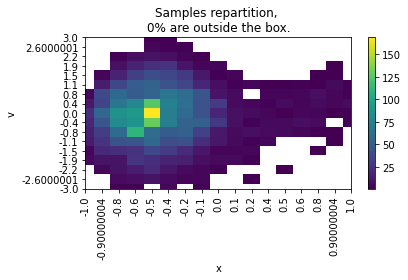

In [5]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

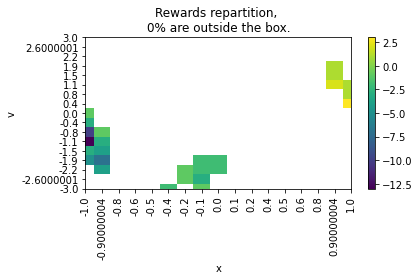

In [6]:
samples_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Collect weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer
from pbo.networks.learnable_q import FullyConnectedQ


weights_buffer = WeightsBuffer()

# Add the validation weights
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=2,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=None,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
validation_weights = q.to_weights(q.params)
weights_buffer.add(validation_weights)

# Add random weights
q_random = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=2,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

while len(weights_buffer) < n_weights:
    weights = q_random.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

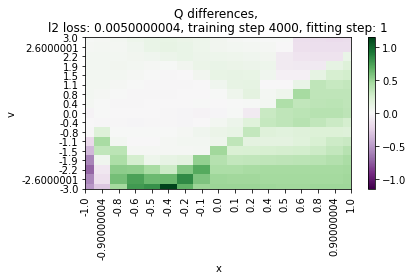

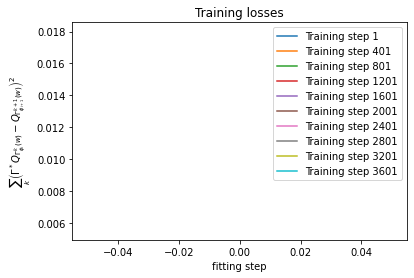

In [8]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate, initial_std)
importance_iteration = jnp.ones(max_bellman_iterations + 1)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params
    best_loss = float('inf')
    patience = 0

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss
        if cumulative_l2_loss < best_loss:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1

        if patience > max_patience:
            break

    if (training_step + 1) % plot_freq == 0 or training_step + 1 == training_steps:
        if not pbo.add_infinity:
            q_weight = validation_weights                
            for _ in range(max_bellman_iterations + 3):
                q_weight = pbo(pbo.params, q_weight)
        else:
            q_weight = pbo.fixed_point(pbo.params)
        q.params = q.to_params(q_weight)
        diff_q = env.diff_q_mesh(q, states_x, states_v)

        q_visu_mesh.set_values(diff_q)
        q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}, fitting step: {fitting_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps, max(training_steps // 10, 1)):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

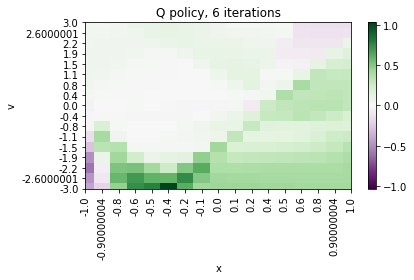

In [9]:
if not pbo.add_infinity:
    test_bellman_iterations = max_bellman_iterations

    q_weight = validation_weights
    for _ in range(test_bellman_iterations):
        q_weight = pbo(pbo.params, q_weight)
else:
    test_bellman_iterations = float("inf")
    q_weight = pbo.fixed_point(pbo.params)

q.params = q.to_params(q_weight)
diff_q = env.diff_q_mesh(q, states_x, states_v)

q_visu_mesh.set_values(diff_q)
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [10]:
# env.simulate(q, horizon, jnp.array([-0.5, 0]))

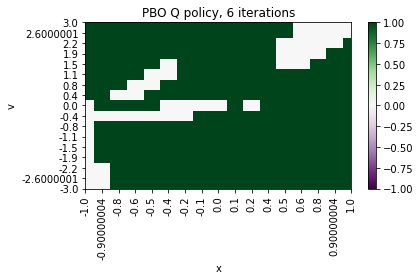

In [11]:
q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show(f"PBO Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

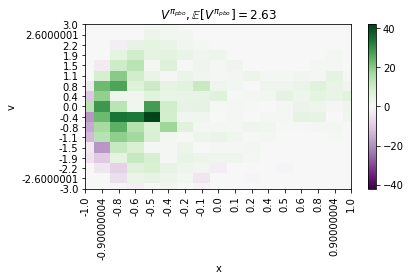

In [12]:
v_mesh_pbo = env.v_mesh(q, horizon, states_x, states_v)

v_mesh_weighted_average = v_mesh_pbo * samples_count

q_visu_mesh.set_values(v_mesh_weighted_average)
q_visu_mesh.show(r"$V^{\pi_{pbo}}, \mathbb{E}\left[ V^{\pi_{pbo}} \right] =$" + str(np.round(np.mean(v_mesh_weighted_average), 2)), xlabel="x", ylabel="v")

## Save the data

In [13]:
from tqdm.notebook import tqdm


iterated_q = np.zeros((max_bellman_iterations_validation + 2, n_states_x, n_states_v, 2))
iterated_v = np.zeros((max_bellman_iterations_validation + 2, n_states_x, n_states_v))
q_weights = validation_weights

q.params = q.to_params(q_weights)
iterated_q[0] = env.q_mesh(q, states_x, states_v)
iterated_v[0] = env.v_mesh(q, horizon, states_x, states_v)

for iteration in tqdm(range(1, max_bellman_iterations_validation + 1)):
    q_weights = pbo(pbo.params, q_weights)

    q.params = q.to_params(q_weights)
    iterated_q[iteration] = env.q_mesh(q, states_x, states_v)
    iterated_v[iteration] = env.v_mesh(q, horizon, states_x, states_v)

q.params = q.to_params(pbo.fixed_point(pbo.params))
iterated_q[max_bellman_iterations_validation + 1] = env.q_mesh(q, states_x, states_v)
iterated_v[max_bellman_iterations_validation + 1] = env.v_mesh(q, horizon, states_x, states_v)

  0%|          | 0/16 [00:00<?, ?it/s]

In [14]:
np.save(f"figures/data/PBO_linear/{max_bellman_iterations}_Q_{seed}.npy", iterated_q)
np.save(f"figures/data/PBO_linear/{max_bellman_iterations}_V_{seed}.npy", iterated_v)